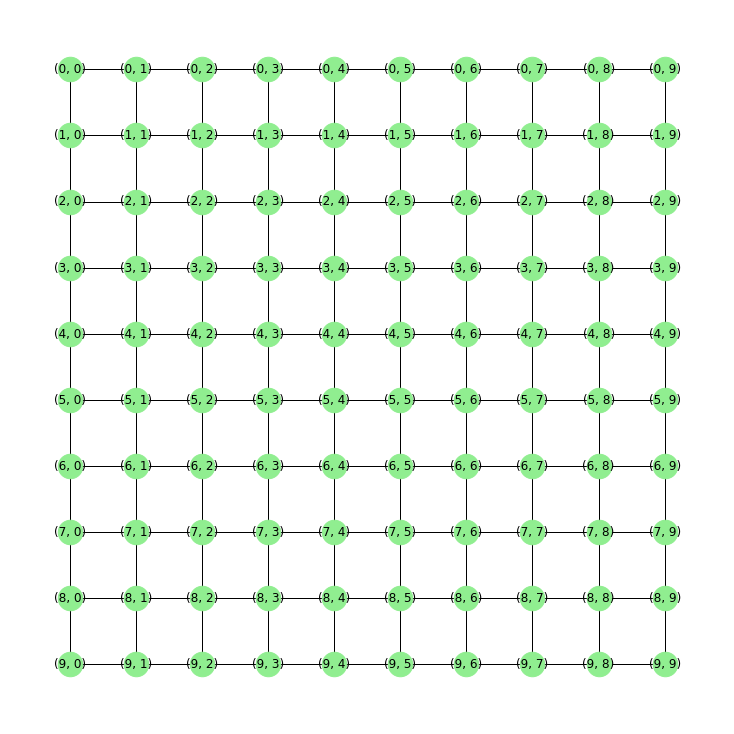

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import sys


L=int(10)
G = nx.grid_2d_graph(L,L, periodic=True)
mapping = {old_label:new_label for new_label, old_label in enumerate(G.nodes())}
H = nx.relabel_nodes(G, mapping)
nx.write_edgelist(H, "ER.txt")
pos = {(x,y):(y,-x) for x,y in G.nodes()}
plt.figure(figsize=(L, L))
nx.draw(G, pos=pos, 
        node_color='lightgreen', 
        with_labels=True,
        node_size=600)
plt.show()